In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from datetime import datetime

from pandas import to_numeric
from scipy.stats import skew  # for some statistics
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from mlxtend.regressor import StackingCVRegressor
from tensorboard.plugins.pr_curve.summary import raw_data_op
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import matplotlib.pyplot as plt
import scipy.stats as stats
import sklearn.linear_model as linear_model
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

In [2]:
raw_data = pd.read_csv(r"data\Patient.csv")
raw_data.head()

# raw_data = pd.read_csv(data_path + dataset_name + '.csv')

,encounter_id,patient_id,hospital_id,age,bmi,elective_surgery,ethnicity,gender,height,icu_admit_source,...,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem,Unnamed: 83,hospital_death
0,66154,25312,118,68.0,22.73,0,Caucasian,M,180.3,Floor,...,1.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular,NaN,0
1,114252,59342,81,77.0,27.42,0,Caucasian,F,160.0,Floor,...,1.0,0.0,0.0,0.0,0.0,0.0,Respiratory,Respiratory,NaN,0
2,119783,50777,118,25.0,31.95,0,Caucasian,F,172.7,Accident & Emergency,...,0.0,0.0,0.0,0.0,0.0,0.0,Metabolic,Metabolic,NaN,0
3,79267,46918,118,81.0,22.64,1,Caucasian,F,165.1,Operating Room / Recovery,...,0.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular,Cardiovascular,NaN,0
4,92056,34377,33,19.0,NaN,0,Caucasian,M,188.0,Accident & Emergency,...,0.0,0.0,0.0,0.0,0.0,0.0,Trauma,Trauma,NaN,0


In [3]:
raw_data.drop(['encounter_id' ,'patient_id' ,'hospital_id','Unnamed: 83'],axis =1, inplace=True)

In [4]:
# 查找数据类型和非数据类型的数据
numerical_col = []
categorical_col = []
for col in raw_data.columns:
    if (raw_data[col].dtype==int)or (raw_data[col].dtype==float):
        numerical_col.append(col)
    elif (raw_data[col].dtype==object):
        categorical_col.append(col)
print (f'Numerical columns:\n\n {numerical_col}')
print("\n"+"-"*150+"\n")
print (f'Categorical columns:\n\n {categorical_col}')

Numerical columns:

 ['age', 'bmi', 'height', 'pre_icu_los_days', 'weight', 'apache_2_diagnosis', 'apache_3j_diagnosis', 'arf_apache', 'gcs_eyes_apache', 'gcs_motor_apache', 'gcs_unable_apache', 'gcs_verbal_apache', 'heart_rate_apache', 'intubated_apache', 'map_apache', 'resprate_apache', 'temp_apache', 'ventilated_apache', 'd1_diasbp_max', 'd1_diasbp_min', 'd1_diasbp_noninvasive_max', 'd1_diasbp_noninvasive_min', 'd1_heartrate_max', 'd1_heartrate_min', 'd1_mbp_max', 'd1_mbp_min', 'd1_mbp_noninvasive_max', 'd1_mbp_noninvasive_min', 'd1_resprate_max', 'd1_resprate_min', 'd1_spo2_max', 'd1_spo2_min', 'd1_sysbp_max', 'd1_sysbp_min', 'd1_sysbp_noninvasive_max', 'd1_sysbp_noninvasive_min', 'd1_temp_max', 'd1_temp_min', 'h1_diasbp_max', 'h1_diasbp_min', 'h1_diasbp_noninvasive_max', 'h1_diasbp_noninvasive_min', 'h1_heartrate_max', 'h1_heartrate_min', 'h1_mbp_max', 'h1_mbp_min', 'h1_mbp_noninvasive_max', 'h1_mbp_noninvasive_min', 'h1_resprate_max', 'h1_resprate_min', 'h1_spo2_max', 'h1_spo2_mi

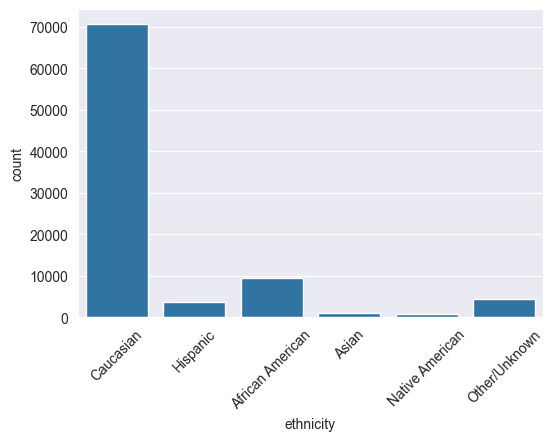

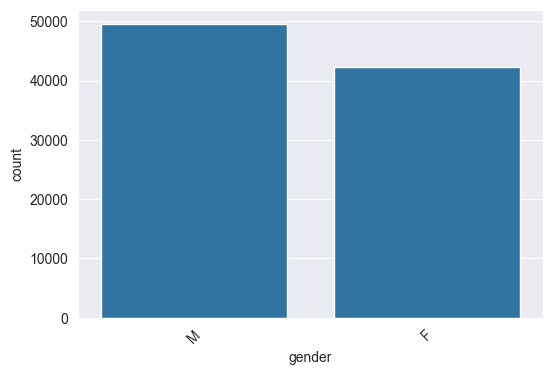

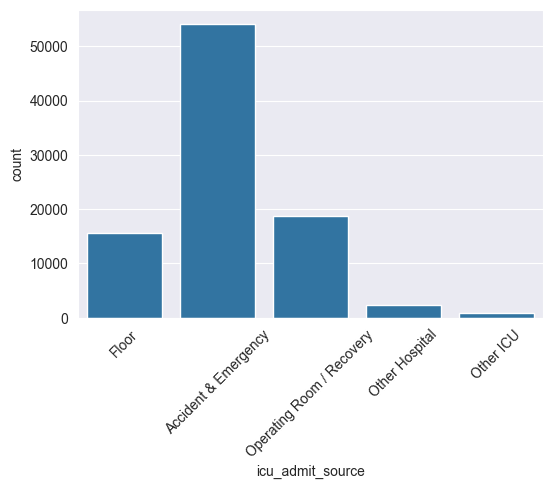

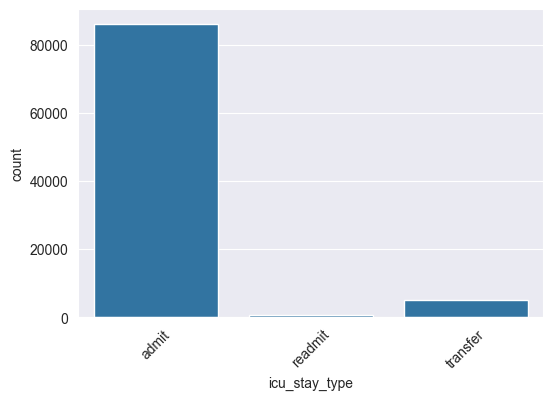

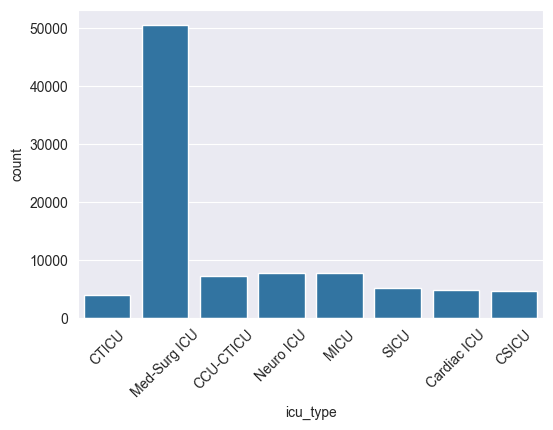

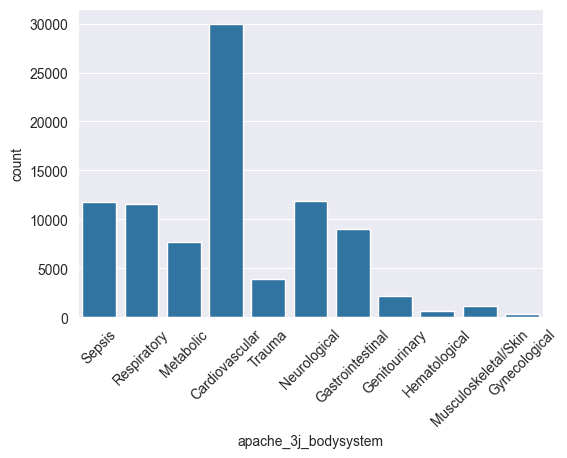

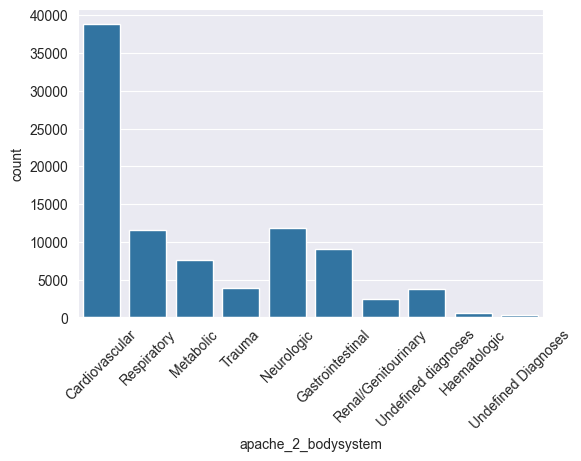

In [5]:
# Plot Categorical columns
for col in categorical_col:
    plt.figure(figsize=(6,4))
    count_plot = sns.countplot(x=raw_data[col])
    #rotate x-axis labels
    count_plot.set_xticklabels(count_plot.get_xticklabels(), rotation=45)
    plt.show()

In [6]:
# 查找空数据比例
raw_data.isnull().sum()*100/len(raw_data)

age                            4.610033
bmi                            3.738837
elective_surgery               0.000000
ethnicity                      1.521049
gender                         0.027259
                                 ...   
lymphoma                       0.779606
solid_tumor_with_metastasis    0.779606
apache_3j_bodysystem           1.812175
apache_2_bodysystem            1.812175
hospital_death                 0.000000
Length: 81, dtype: float64

In [7]:
from sklearn.impute import KNNImputer
import pandas as pd

# 复制数据
data = raw_data.copy()

# 将数值型数据和对象型数据分开
numeric_cols = data.select_dtypes(include=['float64', 'int64']).columns
object_cols = data.select_dtypes(include=['object']).columns
# 对对象型列中的缺失值填充'Unknown'
data[object_cols] = data[object_cols].fillna('Unknown')
# 对数值型列应用KNNImputer填充缺失值
knn_imputer = KNNImputer(n_neighbors=10)
data[numeric_cols] = pd.DataFrame(knn_imputer.fit_transform(data[numeric_cols]), columns=numeric_cols)
# 独热编码对象型列
data = pd.get_dummies(data, columns=object_cols, drop_first=True)

# 检查是否有剩余的缺失值
print(data.isnull().sum())


age                                        0
bmi                                        0
elective_surgery                           0
height                                     0
icu_id                                     0
                                          ..
apache_2_bodysystem_Respiratory            0
apache_2_bodysystem_Trauma                 0
apache_2_bodysystem_Undefined Diagnoses    0
apache_2_bodysystem_Undefined diagnoses    0
apache_2_bodysystem_Unknown                0
Length: 117, dtype: int64


In [9]:
import pandas as pd

# 假设 data 是已经加载的数据
# 如果 data 还没有加载，可以先加载它，例如：

# 查看重复列
duplicate_columns = data.columns[data.columns.duplicated()]
print(duplicate_columns)
# 如果有重复列,删除重复列
# data = data.loc[:, ~data.columns.duplicated()]

# 查看清理后的数据
# print(data.head())


Index([], dtype='object')


In [10]:
data.head()

,age,bmi,elective_surgery,height,icu_id,pre_icu_los_days,weight,apache_2_diagnosis,apache_3j_diagnosis,apache_post_operative,...,apache_2_bodysystem_Gastrointestinal,apache_2_bodysystem_Haematologic,apache_2_bodysystem_Metabolic,apache_2_bodysystem_Neurologic,apache_2_bodysystem_Renal/Genitourinary,apache_2_bodysystem_Respiratory,apache_2_bodysystem_Trauma,apache_2_bodysystem_Undefined Diagnoses,apache_2_bodysystem_Undefined diagnoses,apache_2_bodysystem_Unknown
0,68.0,22.730000,0.0,180.3,92.0,0.541667,73.90,113.0,502.01,0.0,...,False,False,False,False,False,False,False,False,False,False
1,77.0,27.420000,0.0,160.0,90.0,0.927778,70.20,108.0,203.01,0.0,...,False,False,False,False,False,True,False,False,False,False
2,25.0,31.950000,0.0,172.7,93.0,0.000694,95.30,122.0,703.03,0.0,...,False,False,True,False,False,False,False,False,False,False
3,81.0,22.640000,1.0,165.1,92.0,0.000694,61.70,203.0,1206.03,1.0,...,False,False,False,False,False,False,False,False,False,False
4,19.0,30.956292,0.0,188.0,91.0,0.073611,95.87,119.0,601.01,0.0,...,False,False,False,False,False,False,True,False,False,False


In [11]:
"""
可以检查一下经过KNN和独热编码得到的代码
import pandas as pd

# 假设你已经有一个DataFrame data2
column_headers = data2.columns.to_list()  # 转换为列表
print(column_headers)  # 打印所有列名

# 如果你想将其转为字符串形式输出
# column_headers_str = ", ".join(column_headers)  # 用逗号连接列名
# print(column_headers_str)
"""

'\n可以检查一下经过KNN和独热编码得到的代码\nimport pandas as pd\n\n# 假设你已经有一个DataFrame data2\ncolumn_headers = data2.columns.to_list()  # 转换为列表\nprint(column_headers)  # 打印所有列名\n\n# 如果你想将其转为字符串形式输出\n# column_headers_str = ", ".join(column_headers)  # 用逗号连接列名\n# print(column_headers_str)\n'

In [12]:
# 检查是否有剩余的缺失值
print(data.isnull().sum().sum())
# data

0


In [14]:
header_list = data.columns.tolist()
print(header_list)  

['age', 'bmi', 'elective_surgery', 'height', 'icu_id', 'pre_icu_los_days', 'weight', 'apache_2_diagnosis', 'apache_3j_diagnosis', 'apache_post_operative', 'arf_apache', 'gcs_eyes_apache', 'gcs_motor_apache', 'gcs_unable_apache', 'gcs_verbal_apache', 'heart_rate_apache', 'intubated_apache', 'map_apache', 'resprate_apache', 'temp_apache', 'ventilated_apache', 'd1_diasbp_max', 'd1_diasbp_min', 'd1_diasbp_noninvasive_max', 'd1_diasbp_noninvasive_min', 'd1_heartrate_max', 'd1_heartrate_min', 'd1_mbp_max', 'd1_mbp_min', 'd1_mbp_noninvasive_max', 'd1_mbp_noninvasive_min', 'd1_resprate_max', 'd1_resprate_min', 'd1_spo2_max', 'd1_spo2_min', 'd1_sysbp_max', 'd1_sysbp_min', 'd1_sysbp_noninvasive_max', 'd1_sysbp_noninvasive_min', 'd1_temp_max', 'd1_temp_min', 'h1_diasbp_max', 'h1_diasbp_min', 'h1_diasbp_noninvasive_max', 'h1_diasbp_noninvasive_min', 'h1_heartrate_max', 'h1_heartrate_min', 'h1_mbp_max', 'h1_mbp_min', 'h1_mbp_noninvasive_max', 'h1_mbp_noninvasive_min', 'h1_resprate_max', 'h1_resprat

In [23]:
list1 = ['age', 'bmi', 'elective_surgery', 'height', 'icu_id', 'pre_icu_los_days', 'weight', 'apache_2_diagnosis', 'apache_3j_diagnosis', 'apache_post_operative', 'arf_apache', 'gcs_eyes_apache', 'gcs_motor_apache', 'gcs_unable_apache', 'gcs_verbal_apache', 'heart_rate_apache', 'intubated_apache', 'map_apache', 'resprate_apache', 'temp_apache', 'ventilated_apache', 'd1_diasbp_max', 'd1_diasbp_min', 'd1_diasbp_noninvasive_max', 'd1_diasbp_noninvasive_min', 'd1_heartrate_max', 'd1_heartrate_min', 'd1_mbp_max', 'd1_mbp_min', 'd1_mbp_noninvasive_max', 'd1_mbp_noninvasive_min', 'd1_resprate_max', 'd1_resprate_min', 'd1_spo2_max', 'd1_spo2_min', 'd1_sysbp_max', 'd1_sysbp_min', 'd1_sysbp_noninvasive_max', 'd1_sysbp_noninvasive_min', 'd1_temp_max', 'd1_temp_min', 'h1_diasbp_max', 'h1_diasbp_min', 'h1_diasbp_noninvasive_max', 'h1_diasbp_noninvasive_min', 'h1_heartrate_max', 'h1_heartrate_min', 'h1_mbp_max', 'h1_mbp_min', 'h1_mbp_noninvasive_max', 'h1_mbp_noninvasive_min', 'h1_resprate_max', 'h1_resprate_min', 'h1_spo2_max', 'h1_spo2_min', 'h1_sysbp_max', 'h1_sysbp_min', 'h1_sysbp_noninvasive_max', 'h1_sysbp_noninvasive_min', 'd1_glucose_max', 'd1_glucose_min', 'd1_potassium_max', 'd1_potassium_min', 'apache_4a_hospital_death_prob', 'apache_4a_icu_death_prob', 'aids', 'cirrhosis', 'diabetes_mellitus', 'hepatic_failure', 'immunosuppression', 'leukemia', 'lymphoma', 'solid_tumor_with_metastasis', 'hospital_death', 'ethnicity_Asian', 'ethnicity_Caucasian', 'ethnicity_Hispanic', 'ethnicity_Native American', 'ethnicity_Other/Unknown', 'ethnicity_Unknown', 'gender_M', 'gender_Unknown', 'icu_admit_source_Floor', 'icu_admit_source_Operating Room / Recovery', 'icu_admit_source_Other Hospital', 'icu_admit_source_Other ICU', 'icu_admit_source_Unknown', 'icu_stay_type_readmit', 'icu_stay_type_transfer', 'icu_type_CSICU', 'icu_type_CTICU', 'icu_type_Cardiac ICU', 'icu_type_MICU', 'icu_type_Med-Surg ICU', 'icu_type_Neuro ICU', 'icu_type_SICU', 'apache_3j_bodysystem_Gastrointestinal', 'apache_3j_bodysystem_Genitourinary', 'apache_3j_bodysystem_Gynecological', 'apache_3j_bodysystem_Hematological', 'apache_3j_bodysystem_Metabolic', 'apache_3j_bodysystem_Musculoskeletal/Skin', 'apache_3j_bodysystem_Neurological', 'apache_3j_bodysystem_Respiratory', 'apache_3j_bodysystem_Sepsis', 'apache_3j_bodysystem_Trauma', 'apache_3j_bodysystem_Unknown', 'apache_2_bodysystem_Gastrointestinal', 'apache_2_bodysystem_Haematologic', 'apache_2_bodysystem_Metabolic', 'apache_2_bodysystem_Neurologic', 'apache_2_bodysystem_Renal/Genitourinary', 'apache_2_bodysystem_Respiratory', 'apache_2_bodysystem_Trauma', 'apache_2_bodysystem_Undefined Diagnoses', 'apache_2_bodysystem_Undefined diagnoses', 'apache_2_bodysystem_Unknown']
list2 = ['age', 'bmi', 'height', 'pre_icu_los_days', 'weight', 'apache_2_diagnosis', 'apache_3j_diagnosis', 'arf_apache', 'gcs_eyes_apache', 'gcs_motor_apache', 'gcs_unable_apache', 'gcs_verbal_apache', 'heart_rate_apache', 'intubated_apache', 'map_apache', 'resprate_apache', 'temp_apache', 'ventilated_apache', 'd1_diasbp_max', 'd1_diasbp_min', 'd1_diasbp_noninvasive_max', 'd1_diasbp_noninvasive_min', 'd1_heartrate_max', 'd1_heartrate_min', 'd1_mbp_max', 'd1_mbp_min', 'd1_mbp_noninvasive_max', 'd1_mbp_noninvasive_min', 'd1_resprate_max', 'd1_resprate_min', 'd1_spo2_max', 'd1_spo2_min', 'd1_sysbp_max', 'd1_sysbp_min', 'd1_sysbp_noninvasive_max', 'd1_sysbp_noninvasive_min', 'd1_temp_max', 'd1_temp_min', 'h1_diasbp_max', 'h1_diasbp_min', 'h1_diasbp_noninvasive_max', 'h1_diasbp_noninvasive_min', 'h1_heartrate_max', 'h1_heartrate_min', 'h1_mbp_max', 'h1_mbp_min', 'h1_mbp_noninvasive_max', 'h1_mbp_noninvasive_min', 'h1_resprate_max', 'h1_resprate_min', 'h1_spo2_max', 'h1_spo2_min', 'h1_sysbp_max', 'h1_sysbp_min', 'h1_sysbp_noninvasive_max', 'h1_sysbp_noninvasive_min', 'd1_glucose_max', 'd1_glucose_min', 'd1_potassium_max', 'd1_potassium_min', 'apache_4a_hospital_death_prob', 'apache_4a_icu_death_prob', 'aids', 'cirrhosis', 'diabetes_mellitus', 'hepatic_failure', 'immunosuppression', 'leukemia', 'lymphoma', 'solid_tumor_with_metastasis']

# 转换为集合
set1 = set(list1)
set2 = set(list2)
print(len(list1))
print(len(list2))
# 找出两个列表中不同的所有元素 (对称差集)
symmetric_difference = list(set1 ^ set2)  # 或者 list(set1.symmetric_difference(set2))
print(f"两个列表不同的所有元素：{symmetric_difference}")  # 输出: 两个列表不同的所有元素：[1, 2, 6, 7]
print(len(symmetric_difference))

117
70
两个列表不同的所有元素：['apache_2_bodysystem_Undefined diagnoses', 'apache_3j_bodysystem_Unknown', 'apache_2_bodysystem_Undefined Diagnoses', 'apache_2_bodysystem_Respiratory', 'icu_admit_source_Other ICU', 'apache_3j_bodysystem_Metabolic', 'apache_3j_bodysystem_Trauma', 'icu_admit_source_Operating Room / Recovery', 'icu_type_Cardiac ICU', 'hospital_death', 'apache_3j_bodysystem_Gynecological', 'icu_admit_source_Floor', 'ethnicity_Unknown', 'apache_2_bodysystem_Renal/Genitourinary', 'apache_3j_bodysystem_Neurological', 'apache_2_bodysystem_Gastrointestinal', 'ethnicity_Hispanic', 'icu_type_SICU', 'apache_3j_bodysystem_Genitourinary', 'icu_type_CSICU', 'icu_type_Neuro ICU', 'icu_type_Med-Surg ICU', 'apache_3j_bodysystem_Gastrointestinal', 'apache_2_bodysystem_Metabolic', 'icu_type_MICU', 'apache_2_bodysystem_Haematologic', 'ethnicity_Native American', 'icu_id', 'gender_Unknown', 'apache_2_bodysystem_Neurologic', 'apache_3j_bodysystem_Respiratory', 'ethnicity_Other/Unknown', 'icu_stay_type_r

In [23]:
from sklearn.model_selection import train_test_split

y = data['hospital_death'].values
x = data.drop(['hospital_death'], axis=1).values

# Perform train test split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

In [24]:
print("==================")
print(x.shape)
# print("==================")
# print(x_train)
print("==================")
print(y.shape)
# print("==================")
# print(y_train)

(91713, 116)
(91713,)


In [25]:
print("==================")
print(x_train.shape)
# print("==================")
# print(x_train)
print("==================")
print(y_train.shape)
# print("==================")
# print(y_train)

(73370, 116)
(73370,)


In [18]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier, HistGradientBoostingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, StratifiedKFold
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score

# 设置 Kfold，交叉采样法拆分数据集
Kfold = StratifiedKFold(n_splits=10)

# 汇总不同模型算法
classifiers = [
    # 主要汇总了三种算法:梯度提升树/SVM/决策树
    SVC(),# SVM的一种变形
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    ExtraTreesClassifier(),
    GradientBoostingClassifier(),
    HistGradientBoostingClassifier(),
    KNeighborsClassifier(),
    LogisticRegression(max_iter=1000),
    LinearDiscriminantAnalysis(),
    XGBClassifier(),
    LGBMClassifier(),
]

# 交叉验证结果
cv_results = []
for classifier in classifiers:
    cv_results.append(cross_val_score(classifier, x_train, y_train,
                                      scoring='accuracy', cv=Kfold, n_jobs=-1))

# 计算均值和标准差
cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(np.mean(cv_result))
    cv_std.append(np.std(cv_result))

# 数据汇总并输出
cvResDf = pd.DataFrame({
    'cv_mean': cv_means,
    'cv_std': cv_std,
    'algorithm': ['SVC', 'DecisionTreeClassifier', 'RandomForestClassifier',
                  'ExtraTreesClassifier', 'GradientBoostingClassifier', 'HistGradientBoostingClassifier',
                  'KNN', 'LogisticRegression', 'LDA', 'XGBoost', 'LGBM']
})

# 打印结果
print(cvResDf)

# 使用条形图进行可视化
bar = sns.barplot(data=cvResDf.sort_values(by='cv_mean', ascending=False),
                  x='cv_mean', y='algorithm')
bar.set(xlim=(0.7, 1.0))

"""
n_splits=10
0   0.922990  0.001526                             SVC
1   0.876506  0.004807          DecisionTreeClassifier
2   0.923318  0.002287          RandomForestClassifier
3   0.922643  0.001899            ExtraTreesClassifier
4   0.924361  0.001855      GradientBoostingClassifier
5   0.924709  0.001513  HistGradientBoostingClassifier
6   0.916014  0.001378                             KNN
7   0.920985  0.001913              LogisticRegression
8   0.916136  0.001810                             LDA
9   0.923768  0.001318                         XGBoost
10  0.924382  0.002256                            LGBM
"""

KeyboardInterrupt: 

Epoch [10/3000], Loss: 0.7003
Epoch [20/3000], Loss: 0.6518
Epoch [30/3000], Loss: 0.5664
Epoch [40/3000], Loss: 0.4432
Epoch [50/3000], Loss: 0.3295
Epoch [60/3000], Loss: 0.2661
Epoch [70/3000], Loss: 0.2391
Epoch [80/3000], Loss: 0.2256
Epoch [90/3000], Loss: 0.2180
Epoch [100/3000], Loss: 0.2128
Epoch [110/3000], Loss: 0.2098
Epoch [120/3000], Loss: 0.2069
Epoch [130/3000], Loss: 0.2046
Epoch [140/3000], Loss: 0.2024
Epoch [150/3000], Loss: 0.2012
Epoch [160/3000], Loss: 0.1996
Epoch [170/3000], Loss: 0.1978
Epoch [180/3000], Loss: 0.1963
Epoch [190/3000], Loss: 0.1949
Epoch [200/3000], Loss: 0.1939
Epoch [210/3000], Loss: 0.1923
Epoch [220/3000], Loss: 0.1910
Epoch [230/3000], Loss: 0.1899
Epoch [240/3000], Loss: 0.1891
Epoch [250/3000], Loss: 0.1879
Epoch [260/3000], Loss: 0.1864
Epoch [270/3000], Loss: 0.1855
Epoch [280/3000], Loss: 0.1847
Epoch [290/3000], Loss: 0.1835
Epoch [300/3000], Loss: 0.1831
Epoch [310/3000], Loss: 0.1821
Epoch [320/3000], Loss: 0.1799
Epoch [330/3000],

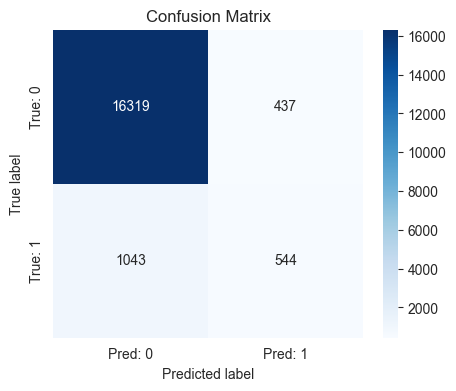

Accuracy: 0.9193
Classification Report:
              precision    recall  f1-score   support

         0.0       0.94      0.97      0.96     16756
         1.0       0.55      0.34      0.42      1587

    accuracy                           0.92     18343
   macro avg       0.75      0.66      0.69     18343
weighted avg       0.91      0.92      0.91     18343



'\nAccuracy: 0.9155\nClassification Report:\n              precision    recall  f1-score   support\n\n         0.0       0.94      0.97      0.95     11154\n         1.0       0.53      0.32      0.40      1066\n\n    accuracy                           0.92     12220\n   macro avg       0.73      0.65      0.68     12220\nweighted avg       0.90      0.92      0.91     12220\n\n'

In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# 转换为 PyTorch tensor
x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
x_test_tensor = torch.tensor(x_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

# 确定设备（使用 GPU 如果可用）
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 将张量移至相应设备
x_train_tensor = x_train_tensor.to(device)
y_train_tensor = y_train_tensor.to(device)
x_test_tensor = x_test_tensor.to(device)
y_test_tensor = y_test_tensor.to(device)

# LSTM 模型
class LSTM_Model(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, output_dim=1, num_layers=2):
        super(LSTM_Model, self).__init__()
        
        # LSTM层，输入数据是 (batch_size, seq_length, input_size)，即 (batch_size, 1, input_dim)
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout=0.3)
        
        # 全连接层
        self.fc = nn.Linear(hidden_dim, output_dim)
        
        # Sigmoid 激活函数用于二分类
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # LSTM 层
        lstm_out, (hn, cn) = self.lstm(x)
        
        # 只取最后一个时间步的输出
        lstm_out = lstm_out[:, -1, :]  # (batch_size, hidden_dim)
        
        # 通过全连接层得到输出
        out = self.fc(lstm_out)
        
        # 使用 Sigmoid 激活函数进行二分类
        out = self.sigmoid(out)
        
        return out

# 训练与评估函数
def train_and_evaluate(model, x_train_tensor, y_train_tensor, x_test_tensor, y_test_tensor, batch_size=64, epochs=10):
    # 损失函数
    criterion = nn.BCELoss()
    
    # 优化器（L2 正则化的权重衰减）
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)  # weight_decay 为 L2 正则化
    
    # 训练过程
    for epoch in range(epochs):
        model.train()  # 设置为训练模式
        optimizer.zero_grad()  # 清空梯度
        output = model(x_train_tensor)  # 前向传播
        loss = criterion(output, y_train_tensor)  # 计算损失
        loss.backward()  # 反向传播
        optimizer.step()  # 更新权重
        
        if (epoch + 1) % 10 == 0:  # 每10个epoch打印一次损失
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')
    
    # 在测试集上评估
    model.eval()  # 设置为评估模式
    with torch.no_grad():
        y_pred = model(x_test_tensor).cpu().numpy()  # 将结果移回 CPU
        y_pred = (y_pred > 0.5).astype(int)  # 将输出转为0或1
    
    # 计算准确率
    accuracy = accuracy_score(y_test_tensor.cpu().numpy(), y_pred)
    
    # 混淆矩阵
    confusion = confusion_matrix(y_test_tensor.cpu().numpy(), y_pred)
    
    # 分类报告
    class_report = classification_report(y_test_tensor.cpu().numpy(), y_pred)
    
    # 绘制混淆矩阵
    fig, ax = plt.subplots(figsize=(5, 4))
    sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', xticklabels=["Pred: 0", "Pred: 1"], yticklabels=["True: 0", "True: 1"])
    plt.title('Confusion Matrix')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    
    # 打印评估结果
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Classification Report:\n{class_report}")
    
    return accuracy, confusion, class_report

# 使用 LSTM 模型
model = LSTM_Model(input_dim=x_train.shape[1])  # 输入数据的维度为 x_train.shape[1]
model = model.to(device)  # 将模型移至设备（GPU 或 CPU）

# 将数据转换为三维张量 (batch_size, seq_length, input_size)
x_train_tensor = x_train_tensor.unsqueeze(1)  # 添加一个时间步维度
x_test_tensor = x_test_tensor.unsqueeze(1)  # 添加一个时间步维度

# 训练并评估
accuracy, confusion, class_report = train_and_evaluate(model, x_train_tensor, y_train_tensor, x_test_tensor, y_test_tensor, epochs=3000)

"""
Accuracy: 0.9155
Classification Report:
              precision    recall  f1-score   support

         0.0       0.94      0.97      0.95     11154
         1.0       0.53      0.32      0.40      1066

    accuracy                           0.92     12220
   macro avg       0.73      0.65      0.68     12220
weighted avg       0.90      0.92      0.91     12220

"""

### 针对LGBM的优化

In [ ]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV

# 定义LGBMClassifier模型，加入早停策略
lgbm = LGBMClassifier(random_state=42, device='gpu', num_threads=4, bin_construct_sample_cnt=500000)

# 定义参数网格
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [200,500],  # 降低 n_estimators 数量
    'max_depth': [3, 5],  # 限制 max_depth 的选择
    'subsample': [0.8, 1.0],  # 降低 subsample 数量
    'colsample_bytree': [0.8, 1.0],  # 限制列采样
    # 启用 L1 和 L2 正则化
    'lambda_l1': [0.1, 0.5],
    'lambda_l2': [0.1, 0.5],
    'scale_pos_weight': [1, 5],  # 调整样本不均衡问题
}

# 使用网格搜索进行超参数调优，加入早停参数
grid_search = GridSearchCV(estimator=lgbm, param_grid=param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)

# Fit the model with early stopping using cross-validation
grid_search.fit(x_train, y_train)                  # 每100轮显示一次日志

# 输出最佳参数和最佳得分
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation score: ", grid_search.best_score_)


"""
27分5秒
Best parameters found:  {'colsample_bytree': 1.0, 'lambda_l1': 0.5, 'lambda_l2': 0.1, 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 200, 'scale_pos_weight': 1, 'subsample': 0.8}
Best cross-validation score:  0.9264275683232803
"""

### 针对HGBC的优化

In [ ]:
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

# 定义HistGradientBoostingClassifier模型
hist_gbc = HistGradientBoostingClassifier(random_state=42)

# 定义参数网格
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'max_iter': [200, 500,],
    'max_depth': [3, 5, 7],
    'min_samples_leaf': [20, 100],
    'l2_regularization': [0.1, 1.0],
    'max_bins': [255, 512],  # 适用于HistGBC
}

# 使用网格搜索进行超参数调优
grid_search_hist_gbc = GridSearchCV(estimator=hist_gbc, param_grid=param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)

# 执行网格搜索
grid_search_hist_gbc.fit(x_train, y_train)

# 输出最佳参数和最佳得分
print("Best parameters found: ", grid_search_hist_gbc.best_params_)
print("Best cross-validation score: ", grid_search_hist_gbc.best_score_)

'''
2分48秒
Best parameters found:  {'l2_regularization': 1.0, 'learning_rate': 0.05, 'max_bins': 255, 'max_depth': 7, 'max_iter': 200, 'min_samples_leaf': 20}
Best cross-validation score:  0.925425046358115
'''

### 针对GBC的优化

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

# 定义 GradientBoostingClassifier 模型
gbc = GradientBoostingClassifier(random_state=42)

# 定义参数网格
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [200, 500],
    'max_depth': [3, 5, 7],
    'min_samples_leaf': [20, 100],
    'min_samples_split': [2, 5, 10],
    'subsample': [0.8, 1.0],  # 随机采样比例
}

# 使用网格搜索进行超参数调优
grid_search_gbc = GridSearchCV(estimator=gbc, param_grid=param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)

# 执行网格搜索
grid_search_gbc.fit(x_train, y_train)

# 输出最佳参数和最佳得分
print("Best parameters found: ", grid_search_gbc.best_params_)
print("Best cross-validation score: ", grid_search_gbc.best_score_)
# 时间成本太高

### 针对RFC的优化

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# 定义RandomForestClassifier模型
rf_clf = RandomForestClassifier(random_state=42)

# 定义参数网格
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2'],
    'bootstrap': [True, False],
}

# 使用网格搜索进行超参数调优
grid_search_rf = GridSearchCV(estimator=rf_clf, param_grid=param_grid_rf, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)

# 执行网格搜索
grid_search_rf.fit(x_train, y_train)

# 输出最佳参数和最佳得分
print("Best parameters found: ", grid_search_rf.best_params_)
print("Best cross-validation score: ", grid_search_rf.best_score_)


## 融合模型

In [ ]:
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import log_loss
from lightgbm import LGBMClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
import numpy as np

# 使用最佳参数初始化LGBM和HistGBC模型
lgbm = LGBMClassifier(
    colsample_bytree=1.0, lambda_l1=0.5, lambda_l2=0.1,
    learning_rate=0.05, max_depth=5, n_estimators=200,
    scale_pos_weight=1, subsample=0.8, random_state=42
)

hist_gbc = HistGradientBoostingClassifier(
    l2_regularization=1.0, learning_rate=0.05, max_bins=255,
    max_depth=7, max_iter=200, min_samples_leaf=20, random_state=42
)

# 定义带最佳参数的VotingClassifier，使用软投票
voting_clf = VotingClassifier(estimators=[
    ('lgbm', lgbm),
    ('hist_gbc', hist_gbc)
], voting='soft')  # 使用软投票

# 使用StratifiedKFold进行交叉验证
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 初始化列表存储准确率和Log Loss
accuracy_scores = []
log_loss_scores = []

for train_idx, val_idx in kf.split(x_train, y_train):
    # 使用索引进行训练和验证集划分
    X_train, X_val = x_train[train_idx], x_train[val_idx]
    y_train, y_val = y_train[train_idx], y_train[val_idx]
    
    # 训练模型
    voting_clf.fit(X_train, y_train)
    
    # 计算准确率
    accuracy = voting_clf.score(X_val, y_val)
    accuracy_scores.append(accuracy)
    
    # 计算Log Loss
    y_pred_prob = voting_clf.predict_proba(X_val)
    log_loss_score = log_loss(y_val, y_pred_prob)
    log_loss_scores.append(log_loss_score)

# 输出交叉验证结果
print("Average Accuracy: ", np.mean(accuracy_scores))
print("Accuracy Std Dev: ", np.std(accuracy_scores))
print("Average Log Loss: ", np.mean(log_loss_scores))
print("Log Loss Std Dev: ", np.std(log_loss_scores))
"""
Average Accuracy:  0.9257523806932578
Accuracy Std Dev:  0.000666247296989349
Average Log Loss:  0.20167774905600672
Log Loss Std Dev:  0.0014232407829795051
"""

In [26]:
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import log_loss, accuracy_score
from sklearn.linear_model import LogisticRegression
import numpy as np

# 使用最佳参数初始化模型
rf_clf = RandomForestClassifier(
    bootstrap=False, max_depth=None, max_features='sqrt', min_samples_leaf=2,
    min_samples_split=10, n_estimators=200, random_state=42
)

lgbm_clf = LGBMClassifier(
    colsample_bytree=1.0, lambda_l1=0.5, lambda_l2=0.1,
    learning_rate=0.05, max_depth=5, n_estimators=200,
    scale_pos_weight=1, subsample=0.8, random_state=42
)

# 使用 Logistic Regression 作为堆叠分类器的最终分类器
stacking_clf = StackingClassifier(
    estimators=[('rf', rf_clf), ('lgbm', lgbm_clf)],
    final_estimator=LogisticRegression(max_iter=1000, random_state=42)
)

# 使用StratifiedKFold进行交叉验证
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 初始化列表存储准确率和Log Loss
accuracy_scores = []
log_loss_scores = []

# 交叉验证
for train_idx, val_idx in kf.split(x_train, y_train):
    X_train, X_val = x_train[train_idx], x_train[val_idx]
    y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]  # 使用不同变量名来避免覆盖
    
    # 训练Stacking模型
    stacking_clf.fit(X_train, y_train_fold)  # 使用y_train_fold而非y_train
    
    # 计算准确率
    accuracy = stacking_clf.score(X_val, y_val_fold)  # 使用y_val_fold而非y_val
    accuracy_scores.append(accuracy)
    
    # 计算Log Loss
    y_pred_prob = stacking_clf.predict_proba(X_val)
    log_loss_score = log_loss(y_val_fold, y_pred_prob)  # 使用y_val_fold而非y_val
    log_loss_scores.append(log_loss_score)

# 输出交叉验证结果
print("Average Accuracy: ", np.mean(accuracy_scores))
print("Accuracy Std Dev: ", np.std(accuracy_scores))
print("Average Log Loss: ", np.mean(log_loss_scores))
print("Log Loss Std Dev: ", np.std(log_loss_scores))


[LightGBM] [Warning] lambda_l1 is set=0.5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Warning] lambda_l1 is set=0.5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Info] Number of positive: 5063, number of negative: 53633
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015336 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11237
[LightGBM] [Info] Number of data points in the train set: 58696, number of used features: 115
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.086258 -> initscore=-2.360205
[LightGBM] [Info] Start training from score -2.360205
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warn

In [27]:
import joblib
import os

# 训练好模型后保存模型
# 定义模型保存的路径
model_path = 'stacking_model.pkl'

# 训练完整个模型后，将其保存到文件
stacking_clf.fit(x_train, y_train)  # 使用全体训练数据拟合模型
joblib.dump(stacking_clf, model_path)

print(f"Model saved to {model_path}")


[LightGBM] [Warning] lambda_l1 is set=0.5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Warning] lambda_l1 is set=0.5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Info] Number of positive: 6328, number of negative: 67042
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016011 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11399
[LightGBM] [Info] Number of data points in the train set: 73370, number of used features: 115
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.086248 -> initscore=-2.360335
[LightGBM] [Info] Start training from score -2.360335
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warn

## 画出模型趋势图

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, log_loss
from sklearn.tree import DecisionTreeClassifier  # 添加这一行
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import numpy as np

# 使用最佳参数初始化各个模型
rf_clf = RandomForestClassifier(
    bootstrap=False, max_depth=None, max_features='sqrt', min_samples_leaf=2,
    min_samples_split=10, n_estimators=200, random_state=42
)

lgbm_clf = LGBMClassifier(
    colsample_bytree=1.0, lambda_l1=0.5, lambda_l2=0.1,
    learning_rate=0.05, max_depth=5, n_estimators=200,
    scale_pos_weight=1, subsample=0.8, random_state=42
)

# 其他模型的初始化（简化为基础模型）
classifiers = [
    ('Random Forest', rf_clf),
    ('LGBM', lgbm_clf),
    ('Logistic Regression', LogisticRegression(max_iter=1000, random_state=42)),
    ('Decision Tree', DecisionTreeClassifier(random_state=42)),
    ('SVC', SVC(probability=True, random_state=42)),
    ('KNN', KNeighborsClassifier())
]

# 使用Stacking 模型：LGBM 和 RFC
stacking_model = VotingClassifier(estimators=[
    ('rf', rf_clf),
    ('lgbm', lgbm_clf)
], voting='soft')

# 使用StratifiedKFold进行交叉验证
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 初始化 ROC 曲线的数据
fpr_dict = {}
tpr_dict = {}
roc_auc_dict = {}

# 训练每个模型并计算 ROC 曲线
for name, clf in classifiers:
    fpr, tpr, _ = roc_curve(y_train, clf.fit(x_train, y_train).predict_proba(x_train)[:, 1])
    roc_auc = auc(fpr, tpr)
    
    fpr_dict[name] = fpr
    tpr_dict[name] = tpr
    roc_auc_dict[name] = roc_auc

# 计算 Stacking 模型的 ROC 曲线
fpr, tpr, _ = roc_curve(y_train, stacking_model.fit(x_train, y_train).predict_proba(x_train)[:, 1])
roc_auc = auc(fpr, tpr)

fpr_dict['Stacking (LGBM + RFC)'] = fpr
tpr_dict['Stacking (LGBM + RFC)'] = tpr
roc_auc_dict['Stacking (LGBM + RFC)'] = roc_auc

# 绘制 ROC 曲线
plt.figure(figsize=(10, 8))

# 绘制每个模型的 ROC 曲线
for name in classifiers:
    plt.plot(fpr_dict[name[0]], tpr_dict[name[0]], label=f'{name[0]} (AUC = {roc_auc_dict[name[0]]:.2f})')

# 绘制 Stacking 模型的 ROC 曲线
plt.plot(fpr_dict['Stacking (LGBM + RFC)'], tpr_dict['Stacking (LGBM + RFC)'],
         label=f'Stacking (LGBM + RFC) (AUC = {roc_auc_dict["Stacking (LGBM + RFC)"]:.2f})', linestyle='--', color='black')

# 绘制对角线，表示随机分类器
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier (AUC = 0.5)')

# 设置图形属性
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison of Classifiers (Including Stacking Model)')
plt.legend(loc='lower right')

# 显示图形
plt.show()


[LightGBM] [Warning] lambda_l1 is set=0.5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Warning] lambda_l1 is set=0.5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Info] Number of positive: 6328, number of negative: 67042
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022359 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11399
[LightGBM] [Info] Number of data points in the train set: 73370, number of used features: 115
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.086248 -> initscore=-2.360335
[LightGBM] [Info] Start training from score -2.360335
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warn

## 输出修改后的csv文件

In [ ]:
# 将 data2 导出为 CSV 文件
data2.to_csv('Patient.csv', index=False)

print("CSV 文件已导出：data2.csv")


In [28]:
import joblib

model_path = r"F:\desktop\Patientproject\EDA\stacking_model.pkl"
# 加载模型
loaded_model = joblib.load(model_path)
# 检查模型的输入特征数量
if hasattr(loaded_model, 'n_features_in_'):
    input_features_count = loaded_model.n_features_in_
    print("模型期望的输入特征数量:", input_features_count)
else:
    print("模型没有提供输入特征数量的信息，可能是无法直接查看接口数量的模型类型。")


模型期望的输入特征数量: 116


In [ ]:
# 加载模型
loaded_model = joblib.load(model_path)

# 使用加载的模型进行预测
y_pred = loaded_model.predict(x_test)
y_pred_prob = loaded_model.predict_proba(x_test)


In [ ]:
column_names = data.columns.tolist()
print(column_names)